# Long Short-Term Memory (LSTM) for Multivariate Time Series Prediction
# Table of Contents
  
1. Intro
2. 程式碼與說明
3. 分析結果
4. 初步結論

## 1. Intro
以下程式碼以Long Short-Term Memory (LSTM) 進行 Multivariate Time Series Prediction。  
題目一(Q1)的目標是辨識漲跌的起始點，本研究先以過去120天的資料建立模型，預測下一天的漲跌或盤整，待確認模型預測準確度後，再嘗試延伸至更長的預測期間(例如:未來5天，10天，20天...)，進而達到辨識起始點的任務。  

研究中選用了Q1資料集中data_x裡的49個features。而label則選用data_y中的TYPE，即hold, up, down。

## 2. 程式碼與說明

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.utils import np_utils

Using TensorFlow backend.


### 讀取資料
讀取資料並清除遺漏值。遺漏值的處理方式暫時以若當日資料中有缺漏的features，則將當日單筆資料移除。

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y%m%d')

dataset = read_csv('raw.csv',  parse_dates = ['date'], index_col=0, date_parser=parse)
dataset = dataset.iloc[:,:-4]
dataset.dropna()
# summarize first 5 rows
print(dataset.head(5))
# print(dataset.tail(5))
# # save to file
# dataset.to_csv('Q1_dataset.csv')

                  o        h        l        c        v  PE_Ratio  PB_Ratio  \
date                                                                          
2006-01-02  6457.61  6492.92  6424.03  6462.06  4697272      12.8      1.70   
2006-01-03  6476.20  6591.77  6457.09  6591.77  5214136      13.0      1.73   
2006-01-04  6658.32  6670.96  6579.66  6616.44  5910065      13.1      1.74   
2006-01-05  6669.80  6717.12  6666.84  6709.87  5851695      13.3      1.76   
2006-01-06  6757.41  6761.01  6676.65  6694.82  5904757      13.2      1.76   

            Turnover     60MA  30D_MA_slope     ...        Down  Conti Count  \
date                                            ...                            
2006-01-02      0.75  6105.40          4.39     ...      0.0059      1  None   
2006-01-03      0.97  6114.15          4.68     ...      0.0206      2  None   
2006-01-04      1.14  6124.63          4.99     ...      0.0056      1    2R   
2006-01-05      1.03  6137.13          5.32   

### 資料前處理
data_x的features有些單位為百分比，故需要轉換單位。接著需要為非數值型的資料編碼，使其成為類別型資料。下列用Counter以數字列出各個feature轉換後的類別。完成後即可對資料進行標準化，以MinMaxScaler作為標準化的方式。

In [3]:
values = dataset.values
# convert ratio to decimal form
ratio_group=[5,6,7,22,23,24,25]
for i in range(len(ratio_group)):
    values[:,ratio_group[i]] = values[:,ratio_group[i]]/100

# integer encode categories
# 12:MA_slope, 13:bias, 14:CP_slope, 44:Count, 45:K_pattern, 50:Type
ctgs_group=[12,13,14,44,45,50,51] 
encoder = LabelEncoder()
for i in range(len(ctgs_group)):
    values[:,ctgs_group[i]]=encoder.fit_transform(values[:,ctgs_group[i]])

# features category description
from collections import Counter
columns_name=['MA_ slope','bias','CP_slpoe','Count','K_pattern','TYPE','TYPE2']
for i in range(len(ctgs_group)):
    print(columns_name[i]+':')
    print(Counter(dataset.values[:,ctgs_group[i]]))
    print(Counter(values[:,ctgs_group[i]]))

    
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values[:,:49])

# prepare y_label
y_label = values[:,-2]
# one-hot encoding
y_label_onehot = np_utils.to_categorical(y_label)

MA_ slope:
Counter({'Z+0D': 853, 'Z+0.5D': 838, 'Z-0D': 393, 'Z-1.5D': 252, 'Z+1D': 242, 'Z-0.5D': 217, 'Z+1.5D': 113, 'Z-1D': 95})
Counter({1: 853, 0: 838, 5: 393, 6: 252, 3: 242, 4: 217, 2: 113, 7: 95})
bias:
Counter({'Z+0D': 945, 'Z+0.5D': 686, 'Z-0D': 494, 'Z-0.5D': 275, 'Z-1.5D': 183, 'Z+1D': 172, 'Z-1D': 143, 'Z+1.5D': 105})
Counter({1: 945, 0: 686, 5: 494, 4: 275, 6: 183, 3: 172, 7: 143, 2: 105})
CP_slpoe:
Counter({'Z+0D': 733, 'Z+0.5D': 663, 'Z-0D': 447, 'Z-0.5D': 336, 'Z+1D': 242, 'Z-1.5D': 214, 'Z-1D': 188, 'Z+1.5D': 180})
Counter({1: 733, 0: 663, 5: 447, 4: 336, 3: 242, 6: 214, 7: 188, 2: 180})
Count:
Counter({'None': 2246, '2R': 207, '2B': 204, '3B': 97, '3R': 77, '4B': 62, '4R': 33, '5B': 20, '6B': 14, '5R': 12, '6R': 9, '7R': 7, '7B': 6, '8B': 3, '8R': 3, '14B': 1, '9R': 1, '11B': 1})
Counter({17: 2246, 3: 207, 2: 204, 4: 97, 5: 77, 6: 62, 7: 33, 8: 20, 10: 14, 9: 12, 11: 9, 13: 7, 12: 6, 14: 3, 15: 3, 1: 1, 16: 1, 0: 1})
K_pattern:
Counter({'red_lower_shadows>upper_shado

### One-Hot Encoding
data_y中的TYPE除了轉換為類別變數外，還需要one-hot encoding。

In [4]:
# prepare y_label
y_label = values[:,-2]
# one-hot encoding
y_label_onehot = np_utils.to_categorical(y_label)


print(y_label[0])
print(y_label_onehot[0])

1.0
[ 0.  1.  0.]


In [5]:
# Save the reframed dataset
# DataFrame(values,index=dataset.index,columns=dataset.columns).to_csv('Q1_dataset.csv')

### 監督式學習資料集
前面完成資料前處理後，我們進一步將資料集轉為可進行監督式學習的資料集，並將其分割為訓練集與測試集。

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
# specify the number of lag days
n_lag = 120
n_out = 1

print(scaled.shape)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_out)
print(reframed.shape)
# reframed.to_csv('reframe.csv')
print(y_label_onehot.shape)

(3003, 49)
(2883, 5880)
(3003, 3)


In [8]:
# split into train and test sets
values = reframed.values
n_train = 1000
n_test = 250
n_features = 49
train = values[-n_train-n_test:-n_test, :]
test = values[-n_test:, :]
# # split into input and outputs
# n_obs = n_lag * n_features
# train_X = train[:, :n_obs]
# test_X = test[:, :n_obs]
train_X = values[-n_train-n_test:-n_test, :]
test_X = values[-n_test:, :]

train_y = y_label_onehot[-n_train-n_test:-n_test, :]
test_y = y_label_onehot[-n_test:, :]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1000, 5880) 1000 (1000, 3)
(1000, 120, 49) (1000, 3) (250, 120, 49) (250, 3)


### 建立模型
模型設定如下。

Train on 1000 samples, validate on 250 samples
Epoch 1/50
 - 11s - loss: 1.6416 - acc: 0.2630 - val_loss: 1.1500 - val_acc: 0.3000
Epoch 2/50
 - 9s - loss: 1.1915 - acc: 0.4020 - val_loss: 1.2138 - val_acc: 0.4200
Epoch 3/50
 - 9s - loss: 1.0819 - acc: 0.5060 - val_loss: 1.0890 - val_acc: 0.4200
Epoch 4/50
 - 9s - loss: 1.0763 - acc: 0.4500 - val_loss: 1.0892 - val_acc: 0.4200
Epoch 5/50
 - 8s - loss: 1.0630 - acc: 0.4750 - val_loss: 1.1169 - val_acc: 0.4200
Epoch 6/50
 - 9s - loss: 1.0462 - acc: 0.5060 - val_loss: 1.1384 - val_acc: 0.4200
Epoch 7/50
 - 8s - loss: 1.0581 - acc: 0.5050 - val_loss: 1.1314 - val_acc: 0.4200
Epoch 8/50
 - 9s - loss: 1.0315 - acc: 0.5210 - val_loss: 1.1142 - val_acc: 0.4200
Epoch 9/50
 - 9s - loss: 1.0416 - acc: 0.5180 - val_loss: 1.1028 - val_acc: 0.4200
Epoch 10/50
 - 9s - loss: 1.0363 - acc: 0.5150 - val_loss: 1.0984 - val_acc: 0.4200
Epoch 11/50
 - 9s - loss: 1.0319 - acc: 0.5240 - val_loss: 1.1029 - val_acc: 0.4200
Epoch 12/50
 - 9s - loss: 1.0242 - ac

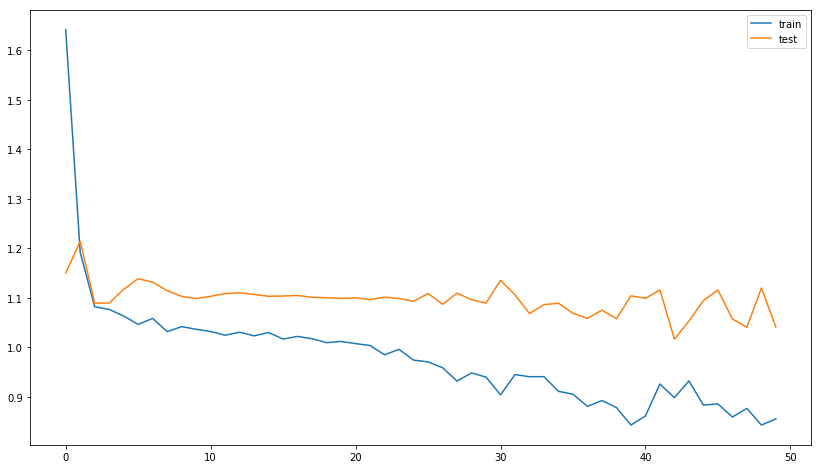

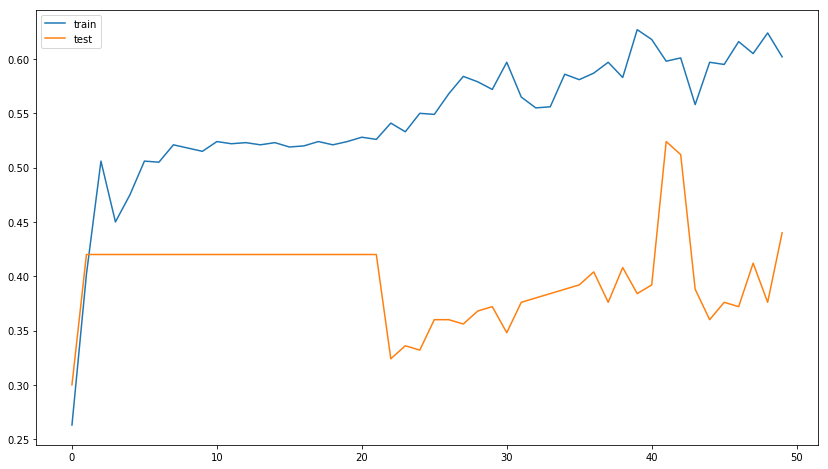

In [9]:
# design network
model = Sequential()
model.add(LSTM(1000, batch_input_shape=(250, train_X.shape[1], train_X.shape[2]), stateful=True))
model.add(Dropout(0.4))
# model.add(LSTM(250, batch_input_shape=(250, train_X.shape[1], train_X.shape[2]), stateful=True))
# model.add(Dropout(0.4))
model.add(Dense(units=50, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=250, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.figure(figsize=(14, 8))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# plot history
pyplot.figure(figsize=(14, 8))
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### 儲存模型
將訓練完成的模型儲存至working directory。

In [10]:
import os
from keras.models import model_from_json

#import os
sCurrentWorkingDirectory = os.getcwd()
print('CurrentWorkingDirectory: ', sCurrentWorkingDirectory)
sDir = sCurrentWorkingDirectory

outputfilename = 'yuanta_Q1'

# serialize model to JSON
model_json = model.to_json()
with open(outputfilename+"_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(outputfilename+"_model" + ".h5")
print("Saved model to disk")


CurrentWorkingDirectory:  D:\ipython\Yuanta Funds\AI_Project
Saved model to disk


### 讀取儲存的模型

In [11]:
# # load json and create model
# json_file = open(outputfilename+'_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights(outputfilename+'_model.h5')
# print("Loaded model from disk")

# # compile network
# model = Sequential()
# model.add(LSTM(1000, batch_input_shape=(250, train_X.shape[1], train_X.shape[2]), stateful=True))
# model.add(Dropout(0.4))
# model.add(Dense(units=50, activation='sigmoid'))
# model.add(Dropout(0.4))
# model.add(Dense(3))
# model.add(Activation('softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 模型摘要

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (250, 1000)               4200000   
_________________________________________________________________
dropout_1 (Dropout)          (250, 1000)               0         
_________________________________________________________________
dense_1 (Dense)              (250, 50)                 50050     
_________________________________________________________________
dropout_2 (Dropout)          (250, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (250, 3)                  153       
_________________________________________________________________
activation_1 (Activation)    (250, 3)                  0         
Total params: 4,250,203
Trainable params: 4,250,203
Non-trainable params: 0
_________________________________________________________________


## 3. 分析結果
### 模型準確度

In [13]:
# model accuracy
scores = model.evaluate(test_X,test_y, batch_size=250, verbose=0)
scores[1]

0.43999999761581421

雖然隨著訓練次數(epoch)，測試資料集的準確度開始上升，但目前模型的設定預測能力不佳，準確度只達到接近44%，需考慮進行更多的參數調整與模型設定。

### 模型預測
使用訓練好的模型對測試資料集進行預測。

In [15]:
# lable dictionary
label_dict={2:'up', 0:'down', 1:'hold'}
print('True Label: ',label_dict)

# make a probability prediction
yhat = model.predict(test_X,batch_size=250)
# class prediction
prediction=model.predict_classes(test_X,batch_size=250)

True Label:  {2: 'up', 0: 'down', 1: 'hold'}


#### 顯示其中一天的預測值與機率

In [22]:
# show prediction probability
def show_predicted_Probability(y_label,prediction,yhat,i):
    print('label:',label_dict[y_label[i][0]],'\n' 
          'predict:',label_dict[prediction[i]],'\n')
    for j in range(3):
        print(label_dict[j]+' Probability: %1.9f'%(yhat[i][j]))

show_predicted_Probability(test_y,prediction,yhat,210)

label: down 
predict: down 

down Probability: 0.411578983
hold Probability: 0.293829978
up Probability: 0.294590950


### Confusion Matrix

In [17]:
# confusion matrix
import pandas as pd
print(label_dict)
pd.crosstab(y_label[-250:],prediction,rownames=['label'],colnames=['predict'])

{2: 'up', 0: 'down', 1: 'hold'}


predict,0,1,2
label,,,
0.0,31,1,14
1.0,46,13,40
2.0,36,3,66


從混淆矩陣中可以看出，目前的模型在預測結果上仍偏重預測下跌。

#### 清理Session並釋放資源

In [23]:
# clear session to release resource
from keras import backend as K
K.clear_session()

## 4. 初步結論
評估結果，受限於目前使用的硬體，故只能採用較簡單的模型設定，導致目前的模型預測能力不佳。為了提高預測準確度，需考慮調整參數與模型設定，例如增加訓練epochs以及加深類神經模型的深度。  


對於股市漲點起始點的辨識，需要進一步定義何謂起始點與結束點，轉換為機器能理解的標籤。